In [288]:
from torchvision import datasets
import numpy as np
from matplotlib import pyplot as plt

(28, 28)


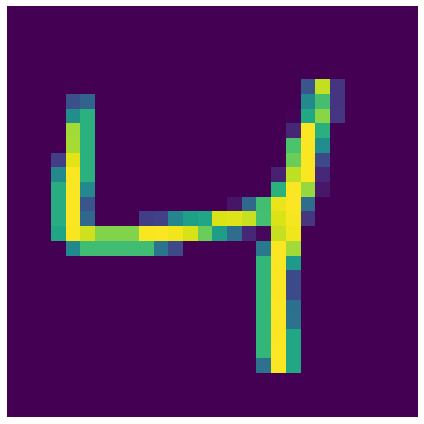

In [289]:
mnist = datasets.MNIST('data', train=True, download=True)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

image_pil = mnist[2][0]
image_np = np.asarray(mnist[2][0]) # To undo: im = PIL.Image.fromarray(numpy.uint8(I))

ax.imshow(image_np)
ax.axis('off')
plt.tight_layout()

print(image_np.shape)

In [290]:
def weights(img):
    channel = 1
    n_row, n_col = img.shape
    
    N = n_row*n_col
    W = np.zeros((N,N))
    
    r = 2
    sigma_I = 0.1
    sigma_X = 1.0
    
    for row_count, row in enumerate(img):
        for col_count, v in enumerate(row):
            index = row_count * n_col + col_count

            search_w = r * 2 + 1
            start_row = row_count - r
            start_col = col_count - r

            for d_row in range(search_w):
                for d_col in range(search_w):
                    new_row = start_row + d_row
                    new_col = start_col + d_col
                    dst = (new_row - row_count) ** 2 + (new_col - col_count) ** 2
                    if 0 <= new_col < n_col and 0 <= new_row < n_row:
                        if dst >= r ** 2:
                            continue

                        cur_index = int(new_row * n_col + new_col)

                        F = img[row_count, col_count] - img[new_row, new_col]
                        if channel == 3:
                            F_diff = F[0]**2 + F[1]**2 + F[2]**2  
                        else:
                            F_diff = F**2

                        w = np.exp(-((F_diff / (sigma_I ** 2)) + (dst / (sigma_X ** 2))))
                        W[index, cur_index] = w

    return W

/tmp/ipykernel_3894/1491859094.py:31: RuntimeWarning: overflow encountered in ubyte_scalars
  F = img[row_count, col_count] - img[new_row, new_col]


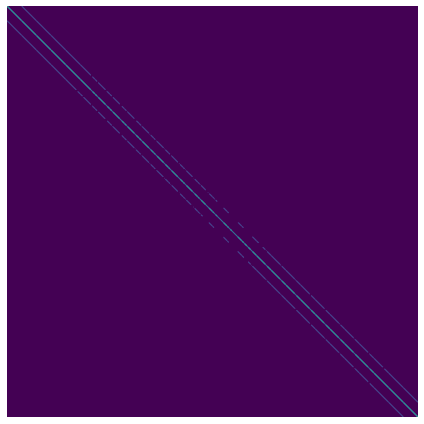

In [291]:
W = weights(image_np)

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))
ax.imshow(W)
ax.axis('off')
plt.tight_layout()

L      - min -0.36787944117144233, max 2.0128588976322206, avg 3.9213709562116286e-19
L_symm - min -0.26894142136999516, max 0.6680893350877163, avg 1.2850714669884606e-06


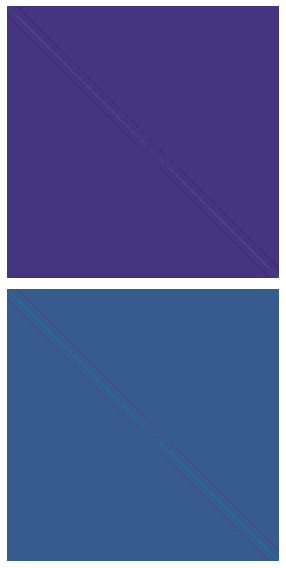

In [292]:
d = np.sum(W, axis=0)
D = np.diagflat(d)

d_sqrt_inv = np.power(np.sqrt(d),-1)
D_sqrt_inv = np.diagflat(d_sqrt_inv)

L = D-W
L_symm = D_sqrt_inv @ (D-W) @ D_sqrt_inv

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(L)
ax[1].imshow(L_symm)
for a in ax:
    a.axis('off')
plt.tight_layout()

print(f'L      - min {np.min(L)}, max {np.max(L)}, avg {np.average(L)}')
print(f'L_symm - min {np.min(L_symm)}, max {np.max(L_symm)}, avg {np.average(L_symm)}')

In [293]:
from scipy.sparse import linalg

# import sys
# sys.path.append("../")
# from nc import NormalizedCuts

# Node = NormalizedCuts(symm_norm_L=True)

# turns despite requesting the correct order it is wrong :)


# TODO: in general
# Lsymm vs L
# eigs, eigh and a few others probably... also sigma for eigs?
# TODO: for this part
# y = D_inv_sqrt * z
# index = np.argsort(lam)
# smallest = y[:, index[1]] # Does this line make any sense at all??? Or is it wrong..


# Current learnings:
# the order is different every time, despite an option which is 'which' = Smallest real.. (more the method used and not the actual thing..)
# changing parameters of the weights (sigma X and sigma I) can lead to zero convergence with ARPACK
# try LAPACK based solvers??

lam_l, z_l = linalg.eigsh(L, which='SA')
index_l = np.argsort(lam_l)
print(lam_l.real)
print(index_l)

print('\n')

lam_lsymm, z_lsymm = linalg.eigsh(L_symm, which='SA')
index_lsymm = np.argsort(lam_lsymm)
print(lam_lsymm.real)
print(index_lsymm)

[-7.16589076e-16 -4.62000380e-16 -1.75025732e-16 -1.53821464e-16
 -1.17861393e-16  1.86851745e-18]
[0 1 2 3 4 5]


[-1.72791530e-16 -7.19810039e-17 -1.10561153e-17 -6.90270993e-18
  5.31351666e-17  2.14758172e-16]
[0 1 2 3 4 5]


In [294]:
y_l = D_sqrt_inv @ z_l
y_lsymm = D_sqrt_inv @ z_lsymm

In [295]:
def plot_6(input, index):
    fig, ax = plt.subplots(nrows=6, sharex=True, sharey=True, figsize=(12, 12))

    for i, a in enumerate(ax):
        a.axis('off')
        a.imshow(np.reshape(input[:, i].real, (28,28)))
        a.set_title(f'{index[i]} - {np.min(input[:, i].real)} - {np.max(input[:, i].real)}')
    plt.tight_layout()

non symmetric


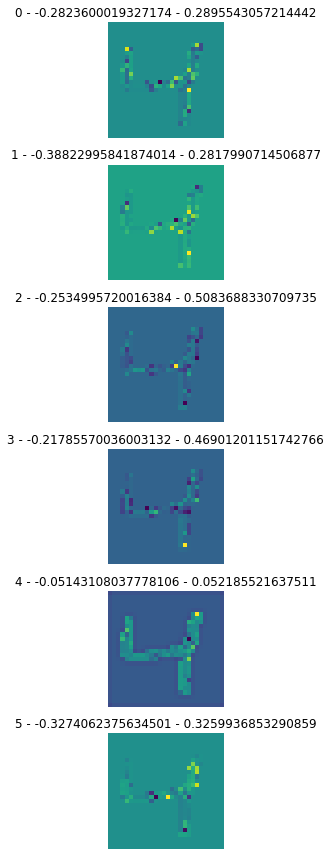

In [296]:
plot_6(y_l, index_l)
print('non symmetric')

symmetric


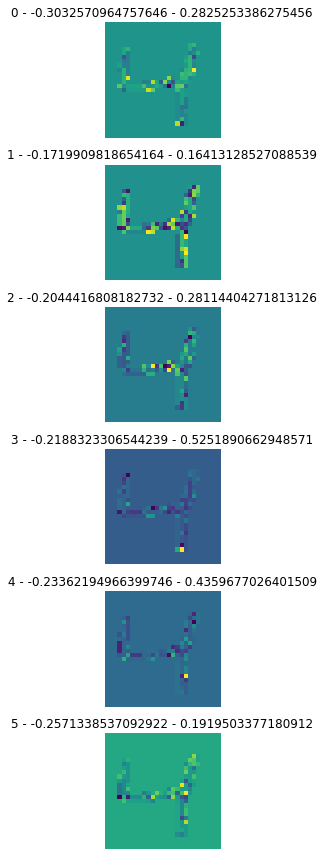

In [297]:
plot_6(y_lsymm, index_lsymm)
print('symmetric')

In [298]:
def partition_by_step(input, D, W):
    step = 50
    pos = input.copy()
    max_value = pos.max()
    min_value = pos.min()
    setp = (max_value - min_value) / step
    dict = {}
    for i in range(1, step):
        partition = (min_value + i * setp)
        temp_pos = pos < partition


        k = (np.sum(W[temp_pos])) / (np.sum(D))
        b = k / (1 - k)

        y = temp_pos.astype('float64') * 2 - b * (temp_pos == False).astype('float64') * 2

        ncut = (y @ (D - W) @ y.T) / (y @ D @ y.T)
        dict[i] = ncut

    min_partition = min_value + min(dict, key=dict.get) * setp
    pos[pos >= min_partition] = 255
    pos[pos < min_partition] = 0

    pos = pos.reshape((28, 28))

    return pos.astype('uint8')

In [299]:
def partition_by_zero(input):
    input = input.reshape((28,28)).astype('float64')   
    input[input>0] = 255
    return input.astype('uint8')

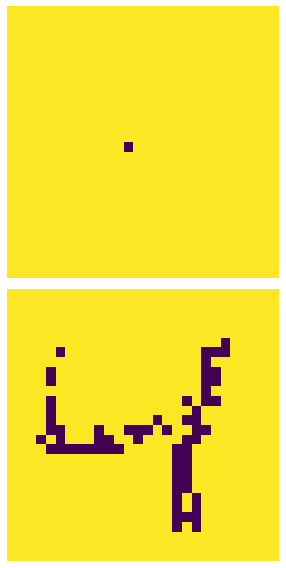

In [300]:

y_l_step = partition_by_step(y_l[:, index_l[0]], D, W)
y_l_zero = partition_by_zero(y_l[:, index_l[0]])

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(y_l_step)
ax[1].imshow(y_l_zero)
for a in ax:
    a.axis('off')
plt.tight_layout()

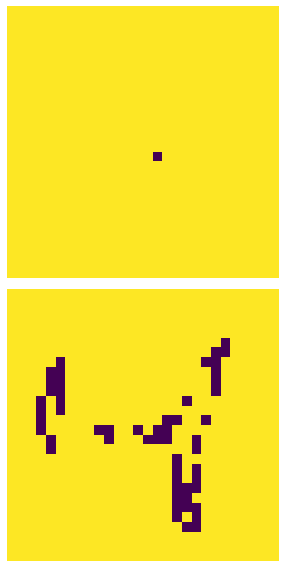

In [301]:
y_lsymm_step = partition_by_step(y_lsymm[:, index_l[0]], D, W)
y_lsymm_zero = partition_by_zero(y_lsymm[:, index_l[0]])

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(y_lsymm_step)
ax[1].imshow(y_lsymm_zero)
for a in ax:
    a.axis('off')
plt.tight_layout()